In [ ]:
! pip install easyocr

In [277]:
! pip install sympy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [278]:
import matplotlib.pylab as plt
import cv2
import numpy as np
import os
import pandas as pd
import sympy

# 載入影像

In [531]:
def avg_circles(circles, b, cull_avg_down=1):
    avg_x=0
    avg_y=0
    avg_r=0
    for i in range(b):
        #optional - average for multiple circles (can happen when a gauge is at a slight angle)
        avg_x = avg_x + circles[0][i][0]
        avg_y = avg_y + circles[0][i][1]
        avg_r = avg_r + circles[0][i][2]
    avg_x = int(avg_x/(b))
    avg_y = int(avg_y/(b))
    avg_r = int(avg_r/(b))


    return avg_x,avg_y,avg_r

def dist_2_pts(x1, y1, x2, y2):
    #print np.sqrt((x2-x1)^2+(y2-y1)^2)
    return np.sqrt((x2 - x1)**2 + (y2 - y1)**2)

def pos_2_angle(x,y,x1,y1,x2,y2):
    dist_pt0 = dist_2_pts(x,y,x1,y1)
    dist_pt1 = dist_2_pts(x,y,x2,y2)
    if (dist_pt0 > dist_pt1):
        xlen= x1-x
        ylen= y-y1
    else:
        xlen= x2-x
        ylen= y-y2
        
    #Taking arc-tan of ylen/xlen to find the angle
    res= np.arctan(np.divide(float(abs(ylen)), float(abs(xlen))))
    res= np.rad2deg(res)
    final_angle  =0
    if xlen<0 and ylen>0:                 #Quadrant 1
        final_angle= res+90
    if xlen>0 and ylen>0:                 #Quadrant 2
        final_angle= 270-res
    if xlen>0 and ylen<0:                 #Quadrant 3
        final_angle= 270+res
    if xlen<0 and ylen<0:                 #Quadrant 4
        final_angle= 90-res
   
    return final_angle

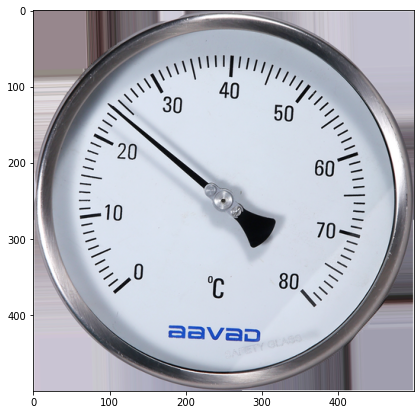

In [568]:
img= cv2.imread('/content/gauge-4.png')[:,:,::-1]

height, width= img.shape[:2]
plt.figure(figsize=(10,7))
plt.imshow(img)
gray= cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) #Convert to gray

# 找圓型

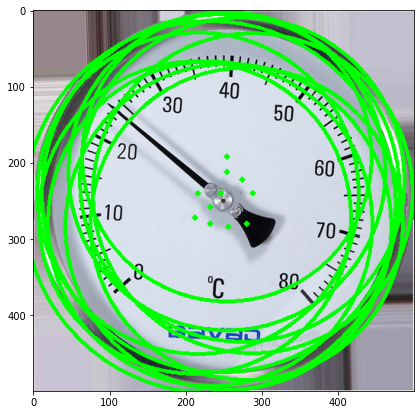

In [569]:
circle_img= cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT,1, 20)#20
a, b, c = circle_img.shape
circle_img = np.uint16(np.around(circle_img))
output2 = img.copy()
for (x,y,r) in circle_img[0,:]:
    cv2.circle(output2, (x,y), r, (0,255,0), 3)
    cv2.circle(output2, (x,y), 2, (0,255,0), 3)


plt.figure(figsize=(10,7))
plt.imshow(output2)

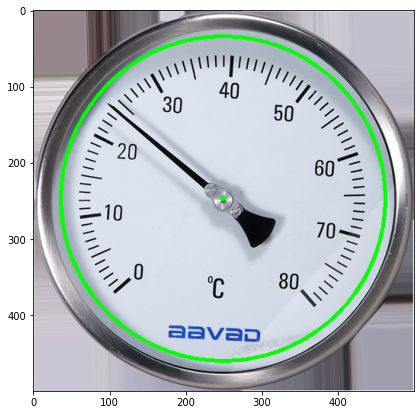

In [570]:
output3 = img.copy()
#Averaging out nearby circles incase
x,y,r = avg_circles(circle_img, b)
cv2.circle(output3, (x,y), r, (0,255,0), 3)
cv2.circle(output3, (x,y), 2, (0,255,0), 3)

plt.figure(figsize=(10,7))
plt.imshow(output3)

In [571]:
height, width

(500, 500)

# 標示圓型度數

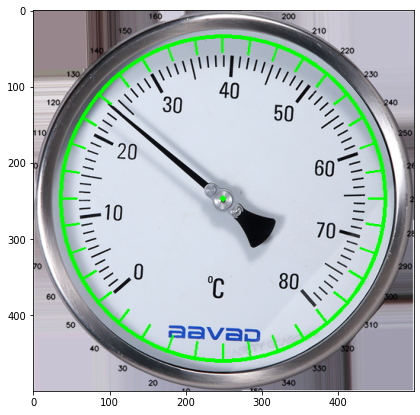

In [572]:
separation= 10 #in degrees
interval = int(360/separation)
p1 = np.zeros((interval,2))  #set empty arrays
p2 = np.zeros((interval,2))
p_text = np.zeros((interval,2))

# 計算圓上點座標，已知半徑、圓心，x1 = x0 + r * cos(angle * PI / 180) y1 = y0 + r * sin(angle * PI /180)
for i in range(0,interval):
    for j in range(0,2):
        if (j%2==0):
            p1[i][j] = x + 0.9 * r * np.cos(separation * i * np.pi / 180) # angle = separation * i
        else:
            p1[i][j] = y + 0.9 * r * np.sin(separation * i * np.pi / 180)

text_offset_x = 10
text_offset_y = 5

for i in range(0, interval):
    for j in range(0, 2):
        if (j % 2 == 0):
            p2[i][j] = x + r * np.cos(separation * i * np.pi / 180)
            p_text[i][j] = x - text_offset_x + 1.2 * r * np.cos((separation) * (i+9) * np.pi / 180) #point for text labels, i+9 rotates the labels by 90 degrees
        else:
            p2[i][j] = y + r * np.sin(separation * i * np.pi/ 180)
            p_text[i][j] = y + text_offset_y + 1.2* r * np.sin((separation) * (i+9) * np.pi / 180)  # point for text labels, i+9 rotates the labels by 90 degrees

#add the lines and labels to the image
for i in range(0,interval):
    cv2.line(output3, (int(p1[i][0]), int(p1[i][1])), (int(p2[i][0]), int(p2[i][1])),(0, 255, 0), 2)
    cv2.putText(output3, '%s' %(int(i*separation)), (int(p_text[i][0]), int(p_text[i][1])), cv2.FONT_HERSHEY_SIMPLEX, 0.3,(0,0,0),1,cv2.LINE_AA)

plt.figure(figsize=(10,7))
plt.imshow(output3)

# 找尋起始值與最終值

In [573]:
import easyocr
reader = easyocr.Reader(['en']) # this needs to run only once to load the model into memory

In [574]:
# 先把輪廓找出來
separation= 10 #in degrees
interval = int(360/separation)
p3 = np.zeros((interval,2))  #set empty arrays
p4 = np.zeros((interval,2))

for i in range(0,interval):
    for j in range(0,2):
        if (j%2==0):
            p3[i][j] = x + 1 *  r * np.cos(separation * i * np.pi / 180) #point for lines
        else:
            p3[i][j] = y + 1 *  r * np.sin(separation * i * np.pi / 180)


region_of_interest_vertices= p3

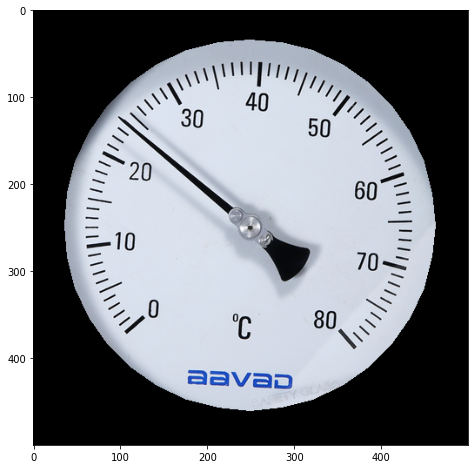

In [575]:
# 遮蔽背景，以方便找出輪廓
def region_of_interest(img, vertices):
    mask= np.zeros_like(img)
    match_mask_color= (255, 255, 255) # White color
    cv2.fillPoly(mask, vertices, match_mask_color)
    masked_image= cv2.bitwise_and(img, mask)
    return masked_image

region_of_interest_vertices= p3
cropped_image= region_of_interest(img, np.array([region_of_interest_vertices], np.int64))
plt.figure(figsize=(10,8))
plt.imshow(cropped_image)

In [576]:
results = reader.readtext(img, allowlist ='0123456789')
threshold = 0.7
pos_list = []
for result in results: 
    if result[2] > threshold:
        print(result)
        pos_list.append([result[0],int(result[1]),result[2]])

pos_list = np.array(pos_list)
pos_list = pos_list[pos_list[:,1].argsort()]

([[242, 92], [276, 92], [276, 122], [242, 122]], '40', 0.9999979769518709)
([[168, 110], [202, 110], [202, 140], [168, 140]], '30', 0.9999978083645809)
([[312, 122], [348, 122], [348, 152], [312, 152]], '50', 0.999994015152757)
([[108, 170], [142, 170], [142, 202], [108, 202]], '20', 0.9952530334016559)
([[368, 194], [398, 194], [398, 220], [368, 220]], '60', 0.9999933408044295)
([[92, 252], [122, 252], [122, 282], [92, 282]], '10', 0.9999989041821146)
([[368, 274], [402, 274], [402, 304], [368, 304]], '70', 0.9999939308592087)
([[320, 342], [356, 342], [356, 372], [320, 372]], '80', 0.9999985670074514)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  if __name__ == '__main__':


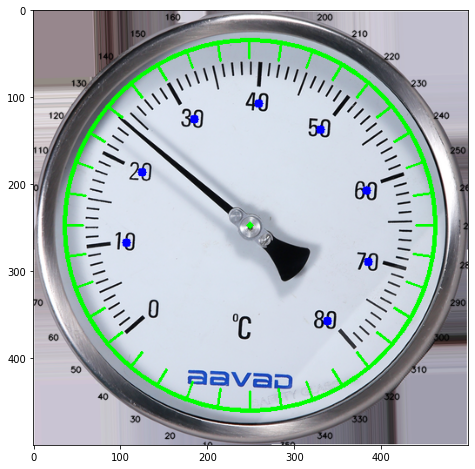

In [577]:
t = output3.copy()
plt.figure(figsize=(12,8))
for pos in pos_list:
    t = cv2.circle(t, (int((pos[0][0][0]+pos[0][1][0])/2),int((pos[0][0][1]+pos[0][3][1])/2)), radius=5, color=(0, 0, 255), thickness=-1)

plt.imshow(t)

In [578]:
min_value_pos = [(pos_list[0][0][0][0]+pos_list[0][0][1][0])/2,(pos_list[0][0][0][1]+pos_list[0][0][3][1])/2]
max_value_pos = [(pos_list[-1][0][0][0]+pos_list[-1][0][1][0])/2,(pos_list[-1][0][0][1]+pos_list[-1][0][3][1])/2]
min_value = pos_list[0][1]
max_value = pos_list[-1][1]

In [579]:
print(f'real max_value {max_value}')
print(f'real min_value {min_value}')

real max_value 80
real min_value 10


In [580]:
min_angle = pos_2_angle(x,y,x,y,min_value_pos[0],min_value_pos[1])
max_angle = pos_2_angle(x,y,x,y,max_value_pos[0],max_value_pos[1])
print(f'real max_angle {max_angle}')
print(f'real min_angle {min_angle}')

real max_angle 321.02399308231963
real min_angle 81.98290692634467


# 找直線

In [581]:
minLineLength = 10
maxlineGap   = 8

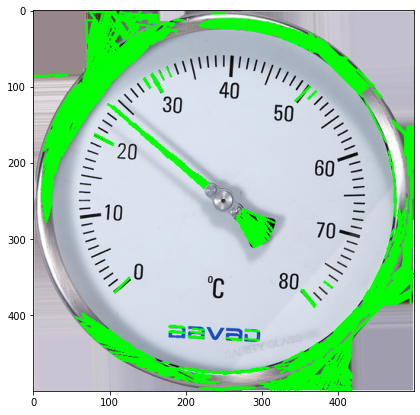

In [582]:
output1 = img.copy()
th, dst2 = cv2.threshold(gray, thresh, maxValue, cv2.THRESH_BINARY_INV)

lines = cv2.HoughLinesP(dst2, 1, np.pi / 180, 100, minLineLength, maxLineGap)
#Visualize the lines
for line in lines:
    x1, y1, x2, y2 =line[0]

    cv2.line(output1, (x1, y1), (x2, y2), (0,255,0), 2)
plt.figure(figsize=(10,7))
plt.imshow(output1)


(144, 159) (210, 213)


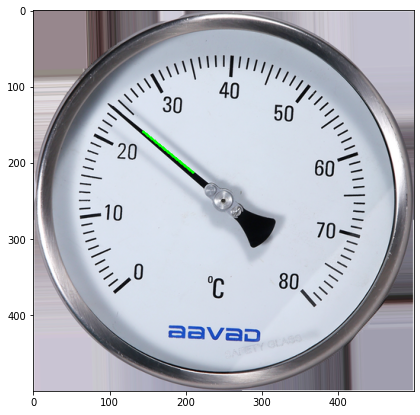

In [583]:
final_line_list = []
#print "radius: %s" %r
output6= img.copy()
# 線不能比半徑r長or短
diff1LowerBound = 0.0 #diff1LowerBound and diff1UpperBound determine how close the line should be from the center
diff1UpperBound = 0.35
diff2LowerBound = 0.5 #diff2LowerBound and diff2UpperBound determine how close the other point of the line should be to the outside of the gauge
diff2UpperBound = 1.5
for i in range(0, len(lines)):
    for x1, y1, x2, y2 in lines[i]:
        diff1 = dist_2_pts(x, y, x1, y1)  # x, y is center of circle
        diff2 = dist_2_pts(x, y, x2, y2)  # x, y is center of circle
        #set diff1 to be the smaller (closest to the center) of the two), makes the math easier
        if (diff1 > diff2):
            temp = diff1
            diff1 = diff2
            diff2 = temp
        # check if line is within an acceptable range
        
        if (((diff1<diff1UpperBound*r) and (diff1>diff1LowerBound*r) and (diff2<diff2UpperBound*r)) and (diff2>diff2LowerBound*r)):
            line_length = dist_2_pts(x1, y1, x2, y2)
            # add to final list
            
            final_line_list.append([x1, y1, x2, y2, line_length])

final_line_list = np.array(final_line_list, dtype=np.int64) 
final_line_list = final_line_list[final_line_list[:, 4].argsort()]         
x1 = final_line_list[-1,0]
y1 = final_line_list[-1,1]
x2 = final_line_list[-1,2]
y2 = final_line_list[-1,3]
print((x1, y1), (x2, y2))
cv2.line(output6, (x1, y1), (x2, y2), (0, 255, 0), 2)
plt.figure(figsize=(10,7))
plt.imshow(output6)


In [584]:
final_angle = pos_2_angle(x,y,x1,y1,x2,y2)

    
final_angle

129.96621304379997

Reading of the Gauge is 24.0512724495831


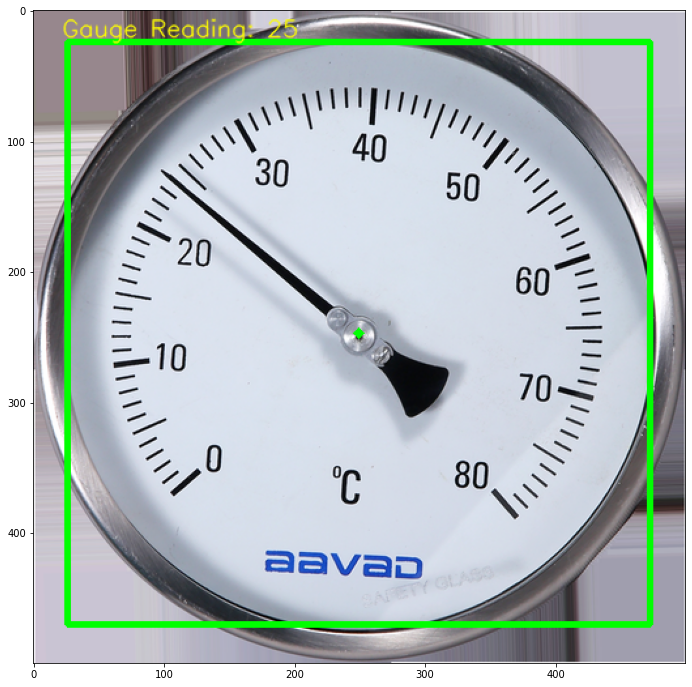

In [585]:
#Converting final angle to gauge reading
import math
output6 = img.copy()
old_min = float(min_angle)
old_max = float(max_angle)

new_min = float(min_value)
new_max = float(max_value)

old_value = final_angle

old_range = (old_max - old_min)
new_range = (new_max - new_min)
new_value = (((old_value - old_min) * new_range) / old_range) + new_min

print(f"Reading of the Gauge is {new_value}")

cv2.rectangle(output6, (x-(r+10), y-(r+10)), (x+(r+10),y+(r+10)), (0,255,0), 3)
cv2.putText(output6, ('Gauge Reading: {}'.format(math.ceil(new_value))), (int(x-(r+14)),int(y-(r+14))),
            cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,0), 1, cv2.LINE_AA )
cv2.circle(output6, (x,y), 2, (0,255,0), 3)

plt.figure(figsize=(15,12))
plt.imshow(output6)